<a href="https://colab.research.google.com/github/IvanKatorgin/Deep-Learning/blob/main/Deep_Learning_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_8_%D0%B4%D0%BE%D0%BF%D0%BE%D0%BB%D0%BD%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Deep Learning". Домашнее задание 8. Дополнительное задание. Рекуррентные сети 3. Каторгин И.П.

## Дополнительное задание
Добавьте в лекционный ноутбук, в функцию train, обучение батчами (дополнительно и необязательно)

In [32]:
%matplotlib inline

In [33]:
from io import open
import unicodedata
import string
import re
import random, math, time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2025-06-19 16:56:01--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.83.69, 18.239.83.32, 18.239.83.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.83.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  4.93MB/s    in 0.6s    

2025-06-19 16:56:02 (4.93 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Itali

In [52]:
!tail data/eng-fra.txt

Five tremors in excess of magnitude 5.0 on the Richter scale have shaken Japan just this week, but scientists are warning that the largest expected aftershock has yet to hit.	Cinq secousses dépassant la magnitude cinq sur l'échelle de Richter ont secoué le Japon précisément cette semaine, mais les scientifiques avertissent que la plus grande réplique est encore à venir.
No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.	Peu importe le temps que tu passeras à essayer de convaincre les gens que le chocolat est de la vanille, ça restera toujours du chocolat, même si tu réussis à convaincre toi et quelques autres que c'est de la vanille.
A child who is a native speaker usually knows many things about his or her language that a non-native speaker who has been studying for years still does not know and perhaps will never know.	Un enfant qui est un locuteur natif

In [53]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [54]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [55]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open(f'data/{lang1}-{lang2}.txt', encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [56]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [57]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['tu es autoritaire non ?', 'you re being bossy aren t you ?']


In [58]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        input_tensor = tensorFromSentence(self.input_lang, pair[0])
        target_tensor = tensorFromSentence(self.output_lang, pair[1])
        return input_tensor, target_tensor

In [59]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    input_seqs, target_seqs = zip(*batch)

    input_lengths = [len(seq) for seq in input_seqs]
    input_padded = torch.nn.utils.rnn.pad_sequence(input_seqs, batch_first=False)

    target_lengths = [len(seq) for seq in target_seqs]
    target_padded = torch.nn.utils.rnn.pad_sequence(target_seqs, batch_first=False)

    return input_padded, input_lengths, target_padded, target_lengths

In [60]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

The Encoder
-----------





In [61]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, -1, self.hidden_size)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

The Decoder
-----------




In [62]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, -1, self.hidden_size)
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [63]:
teacher_forcing_ratio = 0.5

def train_batch(input_batch, input_lengths, target_batch, target_lengths,
               encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    batch_size = input_batch.size(1)
    max_target_length = max(target_lengths)

    loss = 0

    # Encoder forward pass
    encoder_hidden = encoder.initHidden(batch_size)

    for ei in range(input_batch.size(0)):
        encoder_output, encoder_hidden = encoder(input_batch[ei], encoder_hidden)

    # Decoder forward pass
    decoder_input = torch.tensor([[SOS_token]*batch_size], device=device).view(1, batch_size)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = random.random() < teacher_forcing_ratio

    if use_teacher_forcing:
        for di in range(max_target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output.view(batch_size, -1), target_batch[di].view(-1))
            decoder_input = target_batch[di]
    else:
        for di in range(max_target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output.view(batch_size, -1), target_batch[di].view(-1))
            if (decoder_input == EOS_token).all():
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / max_target_length

In [64]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [65]:
def trainIters(encoder, decoder, n_iters, batch_size=32, print_every=1000, plot_every=100, learning_rate=0.01):
    dataset = TranslationDataset(pairs, input_lang, output_lang)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    iter = 0
    while iter < n_iters:
        for input_batch, input_lengths, target_batch, target_lengths in dataloader:
            if iter >= n_iters:
                break

            loss = train_batch(input_batch, input_lengths, target_batch, target_lengths,
                             encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

            print_loss_total += loss
            plot_loss_total += loss
            iter += 1

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)

In [66]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [67]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

2m 25s (- 34m 2s) (5000 6%) 2.2564
4m 52s (- 31m 43s) (10000 13%) 1.7374
7m 16s (- 29m 7s) (15000 20%) 1.4779
9m 41s (- 26m 40s) (20000 26%) 1.2582
12m 12s (- 24m 24s) (25000 33%) 1.0825
14m 34s (- 21m 51s) (30000 40%) 0.9244
16m 58s (- 19m 23s) (35000 46%) 0.7874
19m 22s (- 16m 56s) (40000 53%) 0.6686
21m 45s (- 14m 30s) (45000 60%) 0.5604
24m 6s (- 12m 3s) (50000 66%) 0.4663
26m 25s (- 9m 36s) (55000 73%) 0.3900
28m 46s (- 7m 11s) (60000 80%) 0.3306
31m 9s (- 4m 47s) (65000 86%) 0.2766
33m 29s (- 2m 23s) (70000 93%) 0.2300
35m 47s (- 0m 0s) (75000 100%) 0.1945


<Figure size 640x480 with 0 Axes>

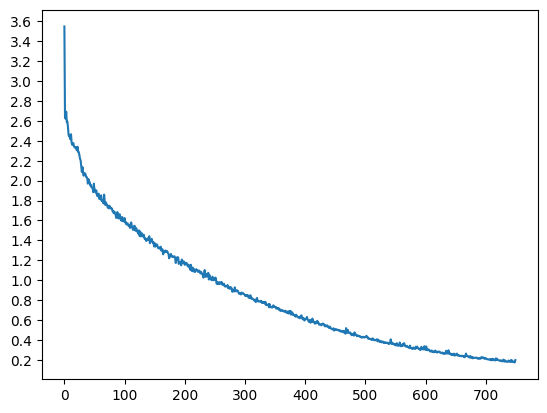

In [68]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 75000, batch_size=64, print_every=5000)

In [69]:
evaluateRandomly(encoder1, decoder1)

> elles sont toutes parties .
= they re all gone .
< they re all against same right . <EOS>

> nous allons travailler ensemble .
= we re going to work together .
< we re going to have is we can t he

> elle est devouee a ses enfants .
= she is devoted to her children .
< she is devoted to her three children . <EOS>

> j en ai marre de ce temps .
= i m fed up with this weather .
< i m fed up with this weather . <EOS>

> vous ne pensez pas clairement .
= you re not thinking clearly .
< you re not supposed to be . <EOS>

> vous etes tres talentueuse .
= you re very talented .
< you re very talented talented . <EOS>

> je suis intrepide .
= i m fearless .
< i m not sure anymore . <EOS>

> j ai peur des chiens .
= i am afraid of dogs .
< i am afraid of making afraid of . <EOS>

> tu es un bon journaliste .
= you re a good journalist .
< you re a little woman now . <EOS>

> je n y excelle pas .
= i m not very good at it .
< i m not very good at all names . <EOS>



## Выводы
Добавление батчей в функцию train увеличило время обучения, но при этом ощутимо выросло качество модели и точность перевода. В итоге предсказанный перевод стал еще сильнее походить на словарный